In [1]:
from pathlib import Path

if not 'workbookDir' in globals():
    PROJECT_DIR = Path.cwd()

## Setup

### Imports

In [ ]:
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
from IPython.display import SVG, display

from scipy.spatial.distance import cdist
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.callbacks import Callback, TensorBoard

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import IncrementalPCA

### Settings

In [3]:
plt.style.use('ggplot')
pd.set_option('float_format', '{:,.2f}'.format)
%matplotlib inline
np.random.seed(42)

In [4]:
LANGUAGES = ['en', 'es']
language_dict = dict(zip(LANGUAGES, ['English', 'Spanish']))

## TED2013 Corpus Statistics

In [5]:
SOURCE = 'TED'
LANGUAGE = 'en'

In [6]:
with pd.HDFStore(Path('vocab', SOURCE, 'vocab.h5')) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: vocab/TED/vocab.h5
/en/ngrams            frame        (shape->[1016,4])   
/en/tokens            frame        (shape->[3130266,3])
/en/vocab             frame        (shape->[46176,1])  
/es/ngrams            frame        (shape->[508,4])    
/es/tokens            frame        (shape->[2938546,3])
/es/vocab             frame        (shape->[74739,1])  
/stats                frame        (shape->[3,2])      


In [7]:
with pd.HDFStore(Path('vocab', SOURCE, 'vocab.h5')) as store:
    df = store['{}/vocab'.format(LANGUAGE)]

wc = df['count'].value_counts().sort_index(ascending=False).reset_index()
wc.columns = ['word_count', 'freq']
wc['n_words'] = wc.word_count.mul(wc.freq)

wc['corpus_share'] = wc.n_words.div(wc.n_words.sum())
wc['coverage'] = wc.corpus_share.cumsum()
wc['vocab_size'] = wc.freq.cumsum()

print('# words: {:,d}'.format(wc.n_words.sum()))
print(wc.loc[:, ['word_count', 'freq', 'n_words', 'vocab_size', 'coverage']].head(10))
print(wc.loc[:, ['word_count', 'freq', 'n_words', 'vocab_size', 'coverage']].tail(10))

# words: 2,710,455
   word_count  freq  n_words  vocab_size  coverage
0      127548     1   127548           1      0.05
1       90702     1    90702           2      0.08
2       74494     1    74494           3      0.11
3       70274     1    70274           4      0.13
4       64387     1    64387           5      0.16
5       56578     1    56578           6      0.18
6       49621     1    49621           7      0.20
7       47404     1    47404           8      0.21
8       46931     1    46931           9      0.23
9       44049     1    44049          10      0.25
     word_count   freq  n_words  vocab_size  coverage
888          10    642     6420       11120      0.97
889           9    778     7002       11898      0.97
890           8    881     7048       12779      0.97
891           7   1143     8001       13922      0.97
892           6   1349     8094       15271      0.98
893           5   1755     8775       17026      0.98
894           4   2484     9936       1951

In [8]:
wc.word_count.div(wc.n_words.sum()).mul(100).describe(percentiles=[.5, .75, .95, .96, .97, .98, .99, .999])

count   898.00
mean      0.09
std       0.30
min       0.00
50%       0.02
75%       0.04
95%       0.31
96%       0.37
97%       0.49
98%       0.62
99%       1.63
99.9%     3.49
max       4.71
Name: word_count, dtype: float64

## Evaluation: Analogies

In [9]:
df = pd.read_csv(Path('data', 'analogies', 'analogies-en.txt'), header=None, names=['category'], squeeze=True)
categories = df[df.str.startswith(':')]
analogies = df[~df.str.startswith(':')].str.split(expand=True)
analogies.columns = list('abcd')

In [10]:
df = pd.concat([categories, analogies], axis=1)
df.category = df.category.ffill()
df = df[df['a'].notnull()]
df.head()

,category,a,b,c,d
1,: capital-common-countries,athens,greece,baghdad,iraq
2,: capital-common-countries,athens,greece,bangkok,thailand
3,: capital-common-countries,athens,greece,beijing,china
4,: capital-common-countries,athens,greece,berlin,germany
5,: capital-common-countries,athens,greece,bern,switzerland


In [11]:
df.groupby('category').size().sort_values(ascending=False)

category
: capital-world                    8556
: city-in-state                    4242
: gram6-nationality-adjective      1640
: gram7-past-tense                 1560
: gram8-plural                     1332
: gram3-comparative                1332
: gram4-superlative                1122
: gram5-present-participle         1056
: gram1-adjective-to-adverb         992
: gram9-plural-verbs                870
: currency                          866
: gram2-opposite                    812
: family                            506
: capital-common-countries          506
dtype: int64

In [12]:
df.groupby('category').first()

,a,b,c,d
category,,,,
: capital-common-countries,athens,greece,baghdad,iraq
: capital-world,abuja,nigeria,accra,ghana
: city-in-state,chicago,illinois,houston,texas
: currency,algeria,dinar,angola,kwanza
: family,boy,girl,brother,sister
: gram1-adjective-to-adverb,amazing,amazingly,apparent,apparently
: gram2-opposite,acceptable,unacceptable,aware,unaware
: gram3-comparative,bad,worse,big,bigger
: gram4-superlative,bad,worst,big,biggest


## `word2vec` - skipgram Architecture using Keras

### Settings

In [13]:
NGRAMS = 3                                # Longest ngram in text
FILE_NAME = 'ngrams_{}'.format(NGRAMS)    # Input to use
MIN_FREQ = 5
SAMPLING_FACTOR = 1e-4
WINDOW_SIZE = 5
EMBEDDING_SIZE = 200
EPOCHS = 1
BATCH_SIZE = 50

# Set up validation
VALID_SET = 10      # Random set of words to get nearest neighbors for
VALID_WINDOW = 150  # Most frequent words to draw validation set from
NN = 10             # Number of nearest neighbors for evaluation

valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)

In [ ]:
path = Path('keras', SOURCE, LANGUAGE, FILE_NAME).resolve()
tb_path = path / 'tensorboard'
if not tb_path.exists():
    tb_path.mkdir(parents=True, exist_ok=True)

### Build Data Set

#### Tokens to ID

1. Extract the top *n* most common words to learn embedding vector for
2. Index these *n* words with unique integers and create an `{index: word}` dictionary
3. Replaced the *n* words in the text with their index value and a dummy value elsewhere

In [14]:
def build_data(language, ngrams=1):
    file_path = PROJECT_DIR / 'vocab' / SOURCE / language / 'ngrams_{}.txt'.format(ngrams)
    words = file_path.read_text().split()
    
    token_counts = [t for t in Counter(words).most_common() if t[1] >= MIN_FREQ]
    tokens, counts = list(zip(*token_counts))
    
    id_to_token = pd.Series(tokens, index=range(1, len(tokens) + 1)).to_dict()
    id_to_token.update({0: 'UNK'})
    token_to_id = {t:i for i, t in id_to_token.items()}
    data = [token_to_id.get(word, 0) for word in words]
    return data, token_to_id, id_to_token

In [15]:
data, token_to_id, id_to_token = build_data(LANGUAGE, ngrams=NGRAMS)

In [16]:
vocab_size = len(token_to_id)

In [17]:
vocab_size

24038

In [18]:
min(data), max(data)

(0, 24037)

In [19]:
s = pd.Series(data).value_counts().reset_index()
s.columns = ['id', 'count']
s['token'] = s.id.map(id_to_token)

In [20]:
s.sort_values('count', ascending=False).head(10)

,id,count,token
0,1,255096,the
1,2,181404,and
2,3,148988,to
3,4,140548,of
4,5,128774,a
5,6,113156,that
6,7,99242,i
7,8,94808,in
8,9,93862,it
9,10,88098,you


In [21]:
s.sort_values('id').token.dropna().to_csv(tb_path / 'meta.tsv', index=False)

#### Analogies to ID

In [22]:
df = pd.read_csv(Path('data', 'analogies', 'analogies-{}.txt'.format(LANGUAGE)), 
                 header=None, squeeze=True)
categories = df[df.str.startswith(':')]
analogies = df[~df.str.startswith(':')].str.split(expand=True)
analogies.columns = list('abcd')

In [23]:
analogies.head()

,a,b,c,d
1,athens,greece,baghdad,iraq
2,athens,greece,bangkok,thailand
3,athens,greece,beijing,china
4,athens,greece,berlin,germany
5,athens,greece,bern,switzerland


In [24]:
analogies_id = analogies.apply(lambda x: x.map(token_to_id))
analogies_id.notnull().all(1).sum()/len(analogies_id)

0.40422180214240705

### Generate Sampling Probabilities

There is an alternative, faster scheme than the traditional SoftMax loss function
called [Noise Contrastive Estimation (NCE)](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).  
Instead of getting the softmax probability for all possible context words, randomly sample 2-20 possible context words and evaluate the probability only for these.

Used for generating the `sampling_table` argument for `skipgrams`. 

`sampling_table[i]` is the probability of sampling the word i-th most common word in a dataset

The sampling probabilities are generated according
to the sampling distribution used in word2vec:

$p(\text{word}) = \min(1, \frac{\sqrt{\frac{\text{word frequency}}{\text{sampling factor}}}}{\frac{\text{word frequency}}{\text{sampling factor}}}$

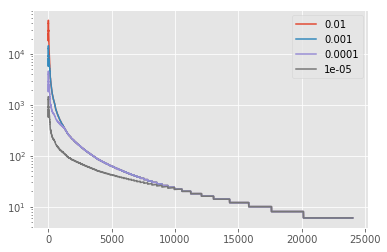

In [25]:
df = s['count'].to_frame('freq')
factors = [1e-2, 1e-3, 1e-4, 1e-5]
for f in factors:
    sf = sequence.make_sampling_table(vocab_size, sampling_factor=f)
    df[f] = df.freq.mul(sf)
df[factors].plot(logy=True);

In [26]:
sampling_table = sequence.make_sampling_table(vocab_size, sampling_factor=SAMPLING_FACTOR)

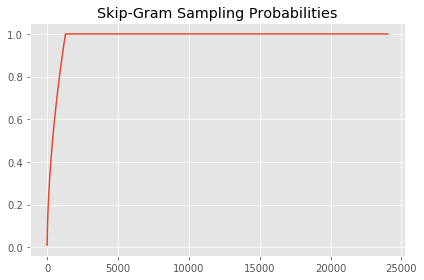

In [27]:
pd.Series(sampling_table).plot(title='Skip-Gram Sampling Probabilities')
plt.tight_layout();

### Generate target-context word pairs

In [28]:
pairs, labels = skipgrams(sequence=data,
                            vocabulary_size=vocab_size,
                            window_size=WINDOW_SIZE,
                            sampling_table=sampling_table,
                            negative_samples=1.0,
                            shuffle=True)

print('{:,d} pairs created'.format(len(pairs)))

35,689,830 pairs created


In [29]:
pairs[:5]

[[122, 99], [1226, 6944], [6529, 8063], [666, 23363], [19601, 20119]]

In [30]:
target_word, context_word = np.array(pairs, dtype=np.int32).T
labels = np.array(labels, dtype=np.int8)
del pairs

In [31]:
target_word[:5]

array([  122,  1226,  6529,   666, 19601], dtype=int32)

In [32]:
df = pd.DataFrame({'target': target_word[:5], 'context': context_word[:5], 'label': labels[:5]})
df

,context,label,target
0,99,1,122
1,6944,0,1226
2,8063,0,6529
3,23363,0,666
4,20119,0,19601


In [33]:
pd.Series(labels).value_counts()

1    17844915
0    17844915
dtype: int64

In [34]:
with pd.HDFStore(path / 'data.h5') as store:
    store.put('id_to_token', pd.Series(id_to_token))

### Define Keras Model Components

#### Scalar Input Variables

In [35]:
input_target = Input((1,), name='target_input')
input_context = Input((1,), name='context_input')

#### Shared Embedding Layer

In [36]:
embedding = Embedding(input_dim=vocab_size, 
                      output_dim=EMBEDDING_SIZE, 
                      input_length=1,
                     name='embedding_layer')

In [37]:
target = embedding(input_target)
target = Reshape((EMBEDDING_SIZE, 1), name='target_embedding')(target)

context = embedding(input_context)
context = Reshape((EMBEDDING_SIZE, 1), name='context_embedding')(context)

#### Create Similarity Measure

In [38]:
dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,), name='similarity')(dot_product)

#### Sigmoid Output Layer

In [39]:
output = Dense(units=1, activation='sigmoid', name='output')(dot_product)

#### Compile Training Model

In [40]:
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

#### Display Architecture

In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 200)       4807600     target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 200, 1)       0           embedding_layer[0][0]            
__________

#### Validation Model

In [42]:
similarity = Dot(normalize=True, 
                 axes=1, 
                 name='cosine_similarity')([target, context])

In [43]:
# create a secondary validation model to run our similarity checks during training
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)

In [44]:
validation_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 200)       4807600     target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 200, 1)       0           embedding_layer[0][0]            
__________

![Keras Graph](assets/keras_graph_tensorboard.png)

### Create Keras Callbacks

####  Nearest Neighors & Analogies

In [45]:
test_set = analogies_id.dropna().astype(int)
a, b, c, actual = test_set.values.T
actual = actual.reshape(-1, 1)
n_analogies = len(actual)

In [46]:
class EvalCallback(Callback):
        
    def on_train_begin(self, logs={}):
        self.eval_nn()
        self.test_analogies()

    def on_train_end(self, logs={}):
        self.eval_nn()

    def on_epoch_end(self, batch, logs={}):
        self.test_analogies()

    @staticmethod
    def test_analogies():
        print('\nAnalogy Accuracy:\n\t', end='')
        embeddings = embedding.get_weights()[0]
        target = embeddings[c] + embeddings[b] - embeddings[a]
        neighbors = np.argsort(cdist(target, embeddings, metric='cosine'))
        match_id = np.argwhere(neighbors == actual)[:, 1]
        print('\n\t'.join(['Top {}: {:.2%}'.format(i, (match_id < i).sum() / n_analogies) for i in [1, 5, 10]]))

    def eval_nn(self):
        print('\n{} Nearest Neighbors:'.format(NN))
        for i in range(VALID_SET):
            valid_id = valid_examples[i]
            valid_word = id_to_token[valid_id]
            similarity = self._get_similiarity(valid_id).reshape(-1)
            nearest = (-similarity).argsort()[1:NN + 1]
            neighbors = [id_to_token[nearest[n]] for n in range(NN)]
            print('{}:\t{}'.format(valid_word, ', '.join(neighbors)))            
        
    @staticmethod
    def _get_similiarity(valid_word_idx):
        target = np.full(shape=vocab_size, fill_value=valid_word_idx)
        context = np.arange(vocab_size)
        return validation_model.predict([target, context])


evaluation = EvalCallback()

#### Tensorboard Callback

In [47]:
tensorboard = TensorBoard(log_dir=str(tb_path),
                          histogram_freq=0,
                          batch_size=32,
                          write_graph=True,
                          embeddings_freq=100,
                          embeddings_metadata=str(tb_path / 'meta.tsv'))

### Train Model

In [48]:
loss = model.fit(x=[target_word, context_word],
                 y=labels,
                 shuffle=True,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[evaluation, tensorboard])

model.save(str(path / 'skipgram_model.h5'))


10 Nearest Neighbors:
've:	relaxed, mute, parcel, strolling, loudspeaker, reserve, beginning, envisioned, louisiana, filth
for:	rhyme, typewriter, traced, bir, academically, resembles, shelter, port, kissed, urethra
kind:	infectious_diseases, wire, 1830s, portraits, snaps, cocoon, dominion, decided, blanket, deneb
time:	paleontologist, bed_nets, baldness, definitions, node, leopard, scrolls, berkley, photoshopped, lgbt
'm:	wounds, civil_rights_movement, anomalies, spines, twittering, laggards, algeria, theories, alma, 87
at:	navigate, item, richest, shuffler, schizophrenic, 1879, synaptic, drives, ice_caps, stereotypical
had:	pearls, maintenance, telemedicine, charcoal, elizabeth, shocked, declined, submissive, populations, tilting
put:	amalgam, adulterous, coastal, banjo, maneuver, compartment, kahn, touch, beers, sharper
your:	skylight, andromeda, eats, spits, mannahatta, jp, worthwhile, climax, swallows, drummer
things:	maps, once, bulldozed, unison, vikings, directors, points, boa

## Optimized TensorFlow Model

Compile custom ops using `compile-ops.sh`.

Run from command line.

In [49]:
# %%bash
# python tensorflow/word2vec.py --language=en --source=Ted --file=ngrams_1 --embedding_size=300 --num_neg_samples=20 --starter_lr=.1 --target_lr=.05 --batch_size=10 --min_count=10 --window_size=10

## word2vec using Gensim

### Evaluation

In [50]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

### Settings

In [51]:
ANALOGIES_PATH = PROJECT_DIR / 'data' / 'analogies' / 'analogies-{}.txt'.format(LANGUAGE)
gensim_path = PROJECT_DIR / 'gensim' / SOURCE / LANGUAGE / FILE_NAME
if not gensim_path.exists():
    gensim_path.mkdir(parents=True, exist_ok=True)

### Sentence Generator

In [52]:
sentence_path = PROJECT_DIR / 'vocab' / SOURCE / LANGUAGE / '{}.txt'.format(FILE_NAME)
sentences = LineSentence(str(sentence_path))

### Model

In [53]:
start = time()

model = Word2Vec(sentences,
                 sg=1,
                 size=300,
                 window=5,
                 min_count=10,
                 negative=10,
                 workers=8,
                 iter=5,
                 alpha=0.05)

model.wv.save(str(gensim_path / 'word_vectors.bin'))
print('Duration: {:,.1f}s'.format(time() - start))

# gensim computes accuracy based on source text files
detailed_accuracy = model.wv.accuracy(str(ANALOGIES_PATH), case_insensitive=True)

# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

Duration: 56.5s
                       category  correct  incorrect  average
4                        family       86        186     0.32
9      gram5-present-participle      198        732     0.21
7             gram3-comparative      255       1005     0.20
8             gram4-superlative       62        490     0.11
12                 gram8-plural      103        827     0.11
14                        total      920       7604     0.11
11             gram7-past-tense      142       1340     0.10
13           gram9-plural-verbs       35        615     0.05
2                 city-in-state       17        429     0.04
6                gram2-opposite        7        299     0.02
1                 capital-world        2         88     0.02
0      capital-common-countries        4        178     0.02
10  gram6-nationality-adjective        6        750     0.01
5     gram1-adjective-to-adverb        3        647     0.00
3                      currency        0         18     0.00
Base Acc

In [58]:
most_sim = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,lear,0.31
1,heels,0.28
2,cobras,0.27
3,shirin,0.27
4,agnes,0.27


In [59]:
similars = pd.DataFrame()
for id in valid_examples:
    word = id_to_token[id]
    similars[word] = [s[0] for s in model.wv.most_similar(id_to_token[id])]
    
similars.T

,0,1,2,3,4,5,6,7,8,9
've,have,’ve,has,got,'d,unknowns,medicalized,been,scholarships,bled
for,of,in,to,and,is,have,a,so,or,that
kind,sort,manipulative,void,semantic,neo,authoring,counterbalance,org_chart,dodecahedron,familiarity
time,moment,cambrian,uninterrupted,way,harriet,familiarity,constants,cape,sunset,and
'm,am,’m,'re,i,woo,optimist,skeptic,technologist,was,dp
at,the,in,and,for,from,is,pebble,icefall,cedars,mater
had,have,was,coached,has,got,could,gunpowder,pierpont,and,did
put,pulls,putting,sew,punched,strap,screamed,insert,snuck,wheeler,turret
your,my,you,their,yourself,steering_wheel,her,spouse,eyeball,purse,erasing
things,distractions,distracting,thing,unknowns,mindsets,milestones,astrolabes,pathologies,sponges,cheetos


#### Continue Training

In [60]:
accuracies = [summary]
for i in range(1, 11):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(str(ANALOGIES_PATH))
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print('{} | Duration: {:,.1f} | Accuracy: {:.2%} '.format(i, time() - start, accuracies[-1][-1]))

pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average']).to_csv(gensim_path / 'accuracies.csv', index=False)
model.wv.save(str(gensim_path / 'word_vectors_final.bin'))

1 | Duration: 30.1 | Accuracy: 9.87% 
2 | Duration: 29.7 | Accuracy: 10.50% 
3 | Duration: 32.2 | Accuracy: 10.28% 
4 | Duration: 32.0 | Accuracy: 10.10% 
5 | Duration: 31.4 | Accuracy: 10.57% 
6 | Duration: 29.9 | Accuracy: 9.89% 
7 | Duration: 30.0 | Accuracy: 10.85% 
8 | Duration: 30.7 | Accuracy: 11.05% 
9 | Duration: 29.5 | Accuracy: 10.71% 
10 | Duration: 29.4 | Accuracy: 11.27% 


## The `google` command-line Tool

### Run from Command Line

In [ ]:
%%bash
file_name=../data/wiki/en/wiki.txt
time ./word2vec -train "$file_name" -output vectors_en.bin - cbow 1 -size 300  -min-count 10  -window 10 -negative 10 -hs 0 -sample 1e-4 -threads 8 -binary 1 -iter 1

### Load Trained Model & Word Vectors via `gensim`

In [61]:
file_name = 'word2vec/word_vectors/vectors_en.bin'
model = KeyedVectors.load_word2vec_format(file_name, binary=True, unicode_errors='ignore')

In [62]:
vectors = model.vectors[:100000]
vectors /= norm(vectors, axis=1).reshape(-1, 1)
vectors.shape

(100000, 300)

In [63]:
words = model.index2word[:100000]
word2id = {w:i for i, w in enumerate(words)}

### Compute Accuracy

In [64]:
analogy_path = PROJECT_DIR / 'data/analogies/analogies-en.txt'
accuracy = model.accuracy(questions=str(analogy_path), restrict_vocab=100000)

In [65]:
summary = accuracy_by_category(accuracy, detail=True)
print('\nOverall Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      459         47     0.91
7             gram3-comparative     1207        125     0.91
10  gram6-nationality-adjective     1472        168     0.90
4                        family      438         68     0.87
1                 capital-world     7058       1132     0.86
12                 gram8-plural     1082        250     0.81
14                        total    17974       6458     0.74
11             gram7-past-tense     1118        442     0.72
9      gram5-present-participle      726        330     0.69
13           gram9-plural-verbs      580        290     0.67
2                 city-in-state     2601       1641     0.61
8             gram4-superlative      605        387     0.61
6                gram2-opposite      254        502     0.34
5     gram1-adjective-to-adverb      312        680     0.31
3                      currency       62        396     0.14

Overall Accuracy: Corre

### Project Data using `tensorboard` Projector

In [66]:
PROJECTION_LIMIT = 10000
proj_path = Path('word2vec', 'projector')
pd.Series(words).iloc[:PROJECTION_LIMIT].to_csv(proj_path / 'meta_data.tsv', index=False, header=None, sep='\t')
pd.DataFrame(vectors).iloc[:PROJECTION_LIMIT].to_csv(proj_path / 'embeddings.tsv', index=False, header=None, sep='\t')

### Project Analogies

In [67]:
pca = IncrementalPCA(n_components=2)

vectors2D = pca.fit_transform(vectors)
pd.Series(pca.explained_variance_ratio_).mul(100)

0   3.69
1   3.19
dtype: float64

In [68]:
results = pd.DataFrame()
correct = incorrect = 0
for section in accuracy:
    correct += len(section['correct'])
    incorrect += len(section['incorrect'])
    df = pd.DataFrame(section['correct']).apply(lambda x: x.str.lower()).assign(section=section['section'])
    results = pd.concat([results, df])

In [72]:
def find_most_similar_analogy(v):
    """Find analogy that most similar in 2D"""
    v1 = vectors2D[v[1]] - vectors2D[v[0]]
    v2 = vectors2D[v[3]] - vectors2D[v[2]]
    idx, most_similar = None, np.inf
    
    for i in range(len(v1)):
        similarity = cosine(v1[i], v2[i])
        if similarity < most_similar:
            idx = i
            most_similar = similarity
    return idx

In [73]:
def get_plot_lims(coordinates):
    xlim, ylim = coordinates.agg(['min', 'max']).T.values
    xrange, yrange = (xlim[1] - xlim[0]) * .1, (ylim[1] - ylim[0]) * .1
    xlim[0], xlim[1] = xlim[0] - xrange, xlim[1] + xrange
    ylim[0], ylim[1] = ylim[0] - yrange, ylim[1] + yrange
    return xlim, ylim

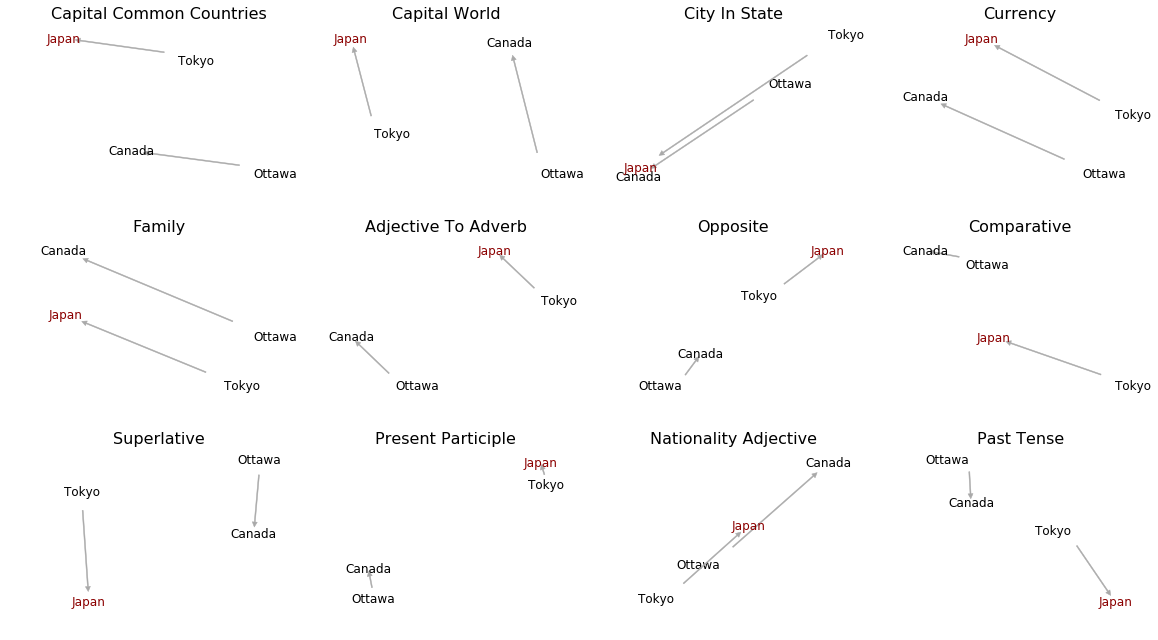

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 9))
axes = axes.flatten()
fc = ec = 'darkgrey'
for s, (section, result) in enumerate(results.groupby('section')):
    if s > 11:
        continue
        
    df = result.drop('section', axis=1).apply(lambda x: x.map(word2id))
    most_similar_idx = find_most_similar_analogy(df)
    
    best_analogy = result.iloc[most_similar_idx, :4].tolist()

    analogy_idx = [words.index(word) for word in best_analogy]
    best_analogy = [a.capitalize() for a in best_analogy]
    
    coords = pd.DataFrame(vectors2D[analogy_idx])  # xy array
    
    xlim, ylim = get_plot_lims(coords)
    axes[s].set_xlim(xlim)
    axes[s].set_ylim(ylim)

    for i in [0, 2]:
        axes[s].annotate(s=analogy[i], xy=coords.iloc[i+1], xytext=coords.iloc[i],
                         arrowprops=dict(width=1,headwidth=5, headlength=5,
                                         fc=fc, ec=ec, shrink=.1),
                         fontsize=12)
    
        axes[s].annotate(analogy[i+1], xy=coords.iloc[i+1],
                         xytext=coords.iloc[i+1],
                         va='center', ha='center',
                         fontsize=12, color='darkred' if i == 2 else 'k');

    axes[s].axis('off')
    title = ' '.join([s.capitalize()
                      for s in section.split('-') if not s.startswith('gram')])
    axes[s].set_title(title, fontsize=16)

fig.tight_layout();
# fig.savefig('analogies.png', dpi=300)